In [2]:
import torch
import torch.nn as nn

from model import *
from config import *

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 11/13/23 10:46:32.153 1181546] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


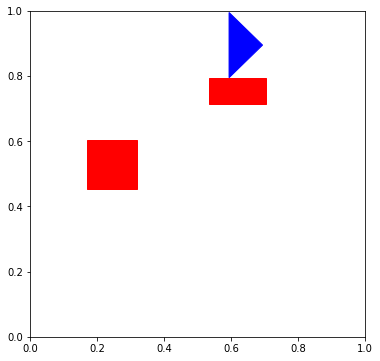

In [3]:
# [Generate Base Data]
import random
from torch.utils.data import DataLoader, Dataset

tri_temp = torch.tensor([[0.0,0.0], [0.1,.1], [.2,0.0]])
tri_hori = torch.tensor([[0.0,0.0], [0.1,.1], [.0,.2]])

def make_data(num_samples = 3):
    all_data = []
    for i in range(num_samples):
        scene = []
        n_rect = random.randint(1,1)
        n_tri = random.randint(0,1)
        n_house = random.randint(0,1)
        n_ship = random.randint(0,1)
        scale = 0.8

        for n in range(n_rect):
            pos = [ random.random() * scale, random.random() *scale]
            scene.append(
                ["rect",0.15 + pos[0],0.15 + pos[1],0.15,0.15]
            )

        for n in range(n_tri):
            pos = [ random.random() * scale, random.random() *scale]
            scene.append(
                ["tri", tri_hori * 1.0 + torch.tensor(pos)]
            )

        for n in range(n_house):
            pos = [ random.random() * scale, random.random() *scale]
            scene.append(
                ["rect",0.15 + pos[0],0.15 + pos[1],0.15,0.15]
            )
            scene.append(
                ["tri", tri_temp * 1.2 + torch.tensor([0.11,0.3]) + torch.tensor(pos)]
            )
        
        for n in range(n_ship):
            pos = [ random.random() * scale, random.random() *scale]
            scene.append(
                ["rect",0.15 + pos[0],0.13 + pos[1],0.17,0.08],
            )
            scene.append(
                ["tri", tri_hori * 1.0 + torch.tensor([0.21,0.21]) + torch.tensor(pos)]
            )
        scene_data = {}
        scene_data["scene"] = scene
        all_data.append(scene_data)
    return all_data

def render(data, ax):
    for obj in data:
        if obj[0] == "rect":
            rect = plt.Rectangle(obj[1:3],obj[3],obj[4], color="red")
            ax.add_patch(rect)
        if obj[0] == "tri":
            poly = plt.Polygon(obj[1],color="blue")
            ax.add_patch(poly)

pos = (0.2,0.2)
data = [
    ["rect",0.15 + pos[0],0.13 + pos[1],0.17,0.08],
    ["tri", tri_hori * 1.0 + torch.tensor([0.21,0.21]) + torch.tensor(pos)]
    ]

fig, ax = plt.subplots(figsize = (6,6))
ax.cla()

data = make_data(1)[0]["scene"]

render(data, ax)
plt.show()

In [4]:
def expat(tens, dim, num):
    rp_tens = tens.unsqueeze(dim)
    rp_shape = [1 for o in rp_tens.shape]
    rp_shape[dim] = num
    output_tensor = rp_tens.repeat(rp_shape)
    return output_tensor

def group_concrete(x, batch = True):
    assert x.min() >= 0.0,print("invalid x < 0.0",x)
    assert x.min() <= 1.0,print("invalid x > 1.0",x)
    if batch:
        x_square = x * x
        concrete_scores = x_square.sum(-1).sum(-1) / x.sum(-1).sum(-1)
        return concrete_scores
    return 

This section is a Graph Abstraction Module that performs graph level segmentation with regularization of natural language.

In [7]:
# [Graph Learner Module]

class GraphAttention(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim = 128):
        super().__init__()
        self.W = nn.Linear(input_dim, latent_dim, bias = False)
        self.a = nn.Linear(latent_dim * 2, 1, bias = False)
    
    def forward(self, x, edges):
        wx = self.W(x)
        attn = self.a(wx)

        return x

class GraphLearner(nn.Module):
    def __init__(self, n_slots = 3, feature_dim = 32):
        super().__init__()
        self.rect_embedding = nn.Linear(1,1)
        self.tri_embedding = nn.Linear(1,1)

        # [2] Object Centric Keys
        self.keys = nn.Parameter(torch.randn([n_slots, feature_dim]))

        # [3] Neuro-Symolic Executor
        self.executor = SceneProgramExecutor(config)    

    def forward(self, input_graph):
        outputs = {}
        return outputs

In [5]:
# [Train Representation]
from tqdm import tqdm

def train(model, dataset, epochs = 100, ckpt_itrs = 20):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_loader = DataLoader(dataset, batch_size = 1, shuffle= True)
    itr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
    for epoch in tqdm(range(epochs)):
        for sample in train_loader:
            outputs = model(sample["image"].to(device))

            masks = outputs["masks"]
            B, N, W, H = masks.shape
            scores = outputs["scores"]
            features = outputs["features"]

            loss = 0.0

            qa_pairs = sample["question"]

            for b in range(B):
                for i,qa_pair in enumerate(qa_pairs):  
                    programs = qa_pair["program"]
                    answers = qa_pair["answer"]              
                    kwargs = {
                    "end":[scores[b]],
                    "features":[features[b]]}

                    q = model.executor.parse(programs[b])
                    o = model.executor(q,**kwargs)
                    ans = answers[b]
                    
                    if ans in ["True","False"]:
                        if itr % ckpt_itrs == 0:print(q,o["end"].sigmoid().detach().numpy(),ans)
                        if ans == "True":
                            loss -= torch.log(torch.sigmoid(o["end"]))
                        else: loss -=  torch.log(1 - torch.sigmoid(o["end"]))
                    else:
                        if itr % ckpt_itrs == 0:print(q,o["end"].detach().numpy()-1, float(answers[b]))
                        loss += torch.nn.functional.mse_loss(torch.tensor(float(answers[b])), o["end"]) * 1.0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if itr % ckpt_itrs == 0:
                pass

In [8]:
config.domain = "demo"
config.concept_type = "cone"
config.concept_dim = 32
glearner = GraphLearner(4, 32)

#print(glearner.executor.all_embeddings()[0])